In [7]:
import h5py

# Open the v7.3+ .mat file using h5py

# This opens the .mat file (which is an HDF5 file under the hood) in read mode ('r').
# The with statement ensures the file is properly closed after use, even if an error occurs
with h5py.File(r'C:\Users\congy\Desktop\Gritton_Lab\Katamine_Data\622\downsampled_LFP.mat', 'r') as f:
    # Print all top-level keys (variable names)
    print(list(f.keys()))
    
    # [:] reads all data from that variable into memory as a NumPy array.
    data = f['data_combine_Low_downsample'][:]  # Read and load into memory
    print(data.shape)
    print(data[:,0].shape)

['data_combine_Low_downsample']
(4968346, 32)
(4968346,)


0
3662


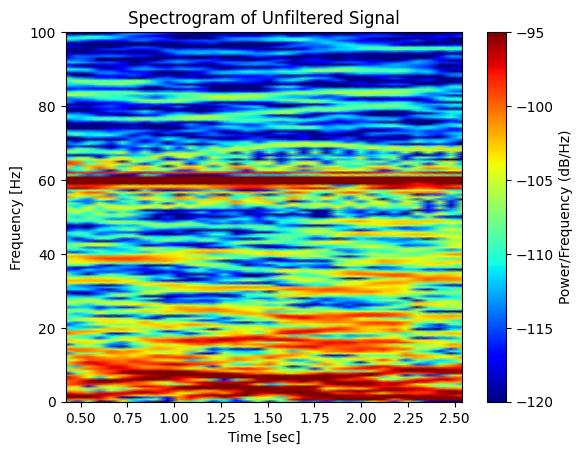

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

## A spectrogram is a visual representation of the frequency content of a signal as it changes over time.
# spectrogram is generated by dividing a signal into short overlapping windows and computing a Fourier
# Transform on each window to extract frequency information

# "Short overlapping windows" refers to how a signal is divided up in time before performing the Fourier Transform to create a spectrogram.

# overlap them (for smoother transitions and better time resolution):

# |-----|
#    |-----|
#       |-----|
        
# nperseg: the number of samples in each window (e.g. 256 samples)
# noverlap: how many samples overlap between windows (e.g. 128 samples)
# each window is indeed an FFT window



# The power values are negative in your spectrogram because the plot is showing power in decibels (dB)

# The bright yellow band around 60 Hz indicates strong power (closer to 0 dB, though still negative).

# The darker colors (purple/blue) indicate much weaker signals.


# Example signal: 5 seconds of a 50 Hz sine wave sampled at 1000 Hz
fs = 24414.0625 / 20  # 1220.703125 Hz

# LPF only cares sound below 100 Hz
# the band below 100 Hz is caused by 60 Hz

# Compute spectrogram
ti=0
tf=3
ti_idx = int(ti * fs)
tf_idx = int(tf * fs)
print(ti_idx)
print(tf_idx)

# LFPs are slow, continuous electrical signals (usually <100 Hz), so your spectrogram settings should prioritize:

# Good frequency resolution to separate low-frequency rhythms (delta, theta, alpha, etc.)
# Moderate time resolution to track rhythm changes or brain state transitions




# Time Resolution = how precisely the spectrogram captures when things happen
# Shorter windows → better time resolution, but worse frequency resolution

# Δt= (N−overlap)/fs = (1250 - 950)/1220.7 = 245.8 ms

# 50 – 250 ms 
# To track how power in each band changes over time
 


# Frequency Resolution = how precisely the spectrogram captures what frequencies are present
# Longer windows → better frequency resolution, but worse time resolution

# Δf= fs/N = 1220.7/1250 = 0.98 Hz  N = window length (e.g., NFFT or nperseg)

# 0.5 – 2 Hz recommended
# To distinguish narrow frequency bands (e.g., 6 Hz vs 8 Hz theta)
 

## FFT stands for Fast Fourier Transform.
# It’s a fast algorithm to compute the Discrete Fourier Transform (DFT),
#which converts a signal from the time domain into the frequency domain.
 


# nperseg = 256  # means 256 samples per FFT window
# Break the signal into chunks (or windows) of 256 samples



#plt.specgram(data[:,0][ti_idx:tf_idx], NFFT=1024, Fs=fs, noverlap=950, scale='dB')
#plt.specgram(data[:,0][ti_idx:tf_idx], NFFT=256, Fs=fs, noverlap=128, scale='dB')
# f, t_spec, Sxx = spectrogram(data[:,0][ti_idx:tf_idx], fs, nperseg=1250, noverlap=950)
  
f, t_spec, Sxx = spectrogram(
    data[:,0][ti_idx:tf_idx],
    fs=fs,
    window=('tukey', 0.25),
    nperseg=1024,       # Number of samples per segment
    noverlap=950,       # Overlap between segments
    nfft=2048,          # FFT length (must be ≥ nperseg)
    detrend='constant',
    return_onesided=True,
    scaling='density',
    mode='psd'
)
# Window duration= nperseg (or NFFT)/fs = 1250 / 1220.7 = 1.02
# 500 ms – 1.5 sec recommended
# Must be long enough to contain ≥2–3 cycles of low-frequency oscillations
# For delta (1–4 Hz), a window of at least 1 sec is often needed to see full cycles

 


#f, t_spec, Sxx = spectrogram(data[:,0][ti_idx:tf_idx], fs, nperseg=64, noverlap=32)
# Plot spectrogram
# shading parameter determines how the color grid cells are drawn and aligned with the data values
# use "nearest" the sharp version to find the appropriate frequency resolution and time resolution
# gouraud smooths the pixels
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-20),  cmap='jet', shading='gouraud')


plt.ylabel('Frequency [Hz]')
plt.ylim(0, 100)
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Unfiltered Signal')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.clim(-120, -95)  # Tighter contrast range
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


(1, 1, 800, 3662)


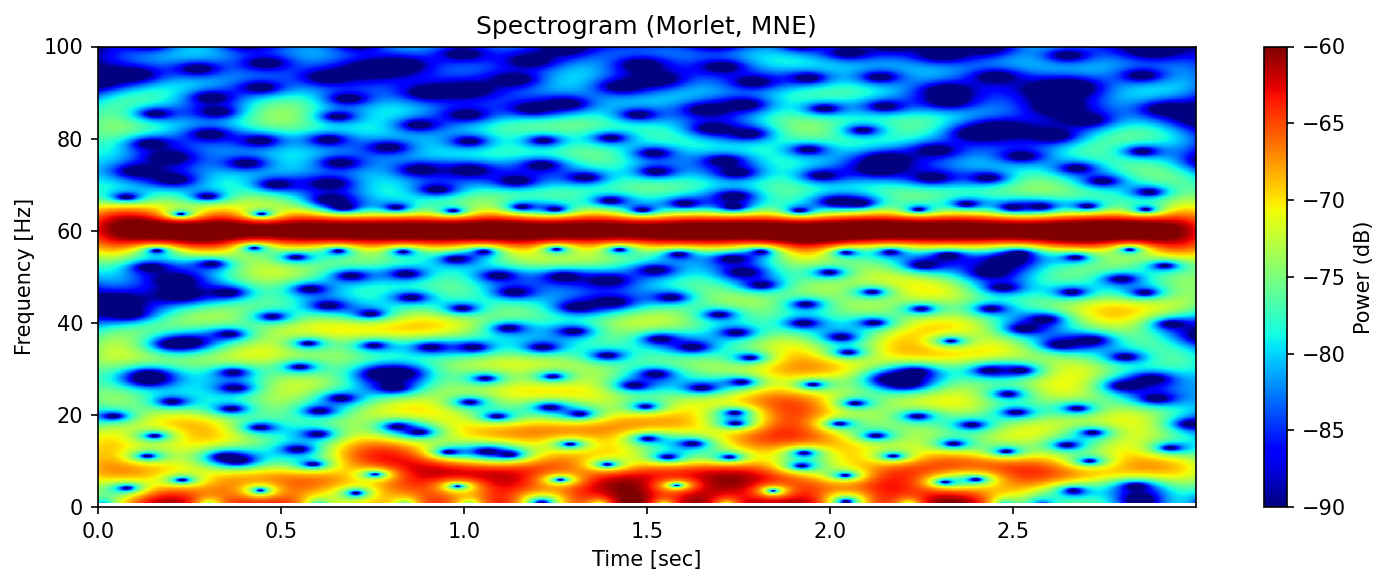

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# tfr_array_morlet performs a wavelet-based time-frequency analysis.
from mne.time_frequency import tfr_array_morlet

# === Load or simulate signal ===
fs = 24414.0625 / 20  # Sampling rate: 1220.703125 Hz
ti = 0  # Start time in seconds
tf = 3  # End time in seconds
ti_idx = int(ti * fs)
tf_idx = int(tf * fs)

# Example: Replace this with your actual LFP data
# Example data shape: (n_samples, n_channels), like (N, 32)
# For demo, we'll use synthetic 60 Hz sine wave
t = np.arange(0, 5, 1/fs)


# Select segment

# data is assumed to be a NumPy array with shape (n_samples, n_channels).
# ti_idx:tf_idx selects a time segment (e.g., 0–3 seconds).
# , 0 selects channel 0 (or whatever channel you're analyzing).

segment = data[ti_idx:tf_idx, 0]
n_times = segment.shape[0]

# Reshape for MNE input: (n_epochs, n_channels, n_times)
# This line reshapes the 1D array into a 3D array so it can be used with MNE’s wavelet transform function
X = segment[np.newaxis, np.newaxis, :]  # shape (1, 1, n_times)

# === Define frequencies of interest and n_cycles ===
freqs = np.linspace(1, 100, 800)  # Focused on 1–100 Hz

# n_cycles controls how many wave cycles per frequency are used in the Morlet wavelets. 
# Higher values improve frequency resolution but reduce time resolution.
n_cycles = freqs / 2  # Controls time-frequency resolution

# === Compute power using Morlet wavelets ===
# power.shape == (n_epochs, n_channels, n_freqs, n_times)
power = tfr_array_morlet(X, sfreq=fs, freqs=freqs,
                         n_cycles=n_cycles, output='power')
print(power.shape)

# === Plot ===

plt.figure(figsize=(10, 4), dpi=150)  # higher DPI for sharper output

time_axis = np.arange(n_times) / fs + ti   # Align time with actual seconds

# Plot spectrogram
# power[0, 0] is the 2D array of power values over time and frequency for one trial and one channel.
plt.pcolormesh(time_axis, freqs, 10 * np.log10(power[0, 0] + 1e-20),cmap='jet', shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 100)
plt.title('Spectrogram (Morlet, MNE)')
plt.colorbar(label='Power (dB)')
plt.clim(-90, -60) # Adjust contrast range
plt.tight_layout()
plt.show()
